# LSTM을 이용한 텍스트 생성
- 데이터 : kaggle _NewYork Time Comments

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
df = pd.read_csv('ArticlesApril2018.csv', encoding = 'latin1')
df.head(3)

,articleID,articleWordCount,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL
0,5adf6684068401528a2aa69b,781,By JOHN BRANCH,article,Former N.F.L. Cheerleadersâ Settlement Offer...,"['Workplace Hazards and Violations', 'Football...",68,Sports,0,2018-04-24 17:16:49,Pro Football,"âI understand that they could meet with us, ...",The New York Times,News,https://www.nytimes.com/2018/04/24/sports/foot...
1,5adf653f068401528a2aa697,656,By LISA FRIEDMAN,article,E.P.A. to Unveil a New Rule. Its Effect: Less ...,"['Environmental Protection Agency', 'Pruitt, S...",68,Climate,0,2018-04-24 17:11:21,Unknown,The agency plans to publish a new regulation T...,The New York Times,News,https://www.nytimes.com/2018/04/24/climate/epa...
2,5adf4626068401528a2aa628,2427,By PETE WELLS,article,"The New Noma, Explained","['Restaurants', 'Noma (Copenhagen, Restaurant)...",66,Dining,0,2018-04-24 14:58:44,Unknown,Whatâs it like to eat at the second incarnat...,The New York Times,News,https://www.nytimes.com/2018/04/24/dining/noma...


## 1.데이터 전처리 : 헤드라인만 사용

In [ ]:
df.headline.isna().sum()

0

In [ ]:
headlines = df.headline.values.tolist()
headlines[:4]

['Former N.F.L. Cheerleadersâ\x80\x99 Settlement Offer: $1 and a Meeting With Goodell',
 'E.P.A. to Unveil a New Rule. Its Effect: Less Science in Policymaking.',
 'The New Noma, Explained',
 'Unknown']

In [ ]:
# Unknown 제거
headlines = [line for line in df.headline.values if line != 'Unknown']
len(headlines)

1214

In [ ]:
# encoding, 구둣점 제거, 소문자로 변환
import re

def preprocessing(s):
    s = s.encode('utf8').decode('ascii', 'ignore')
    s = re.sub('[^A-Za-z0-9 ]', '', s)
    return s.lower()

In [ ]:
headlines = [preprocessing(line) for line in headlines]
headlines[:4]

['former nfl cheerleaders settlement offer 1 and a meeting with goodell',
 'epa to unveil a new rule its effect less science in policymaking',
 'the new noma explained',
 'how a bag of texas dirt  became a times tradition']

### 1.2 keras 텍스트 전처리

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer           # X
from tensorflow.keras.preprocessing.sequence import pad_sequences   # X
from tensorflow.keras.utils import to_categorical                   # y

In [ ]:
token = Tokenizer()
token.fit_on_texts(headlines)        # 머신러닝에서의 fit_transform

In [ ]:
# 단어 집합 크기
vocab_size = len(token.word_index) + 1      # 0때문에 1을 더해줘야 됨.
vocab_size

3494

## 2.Sequence 생성

In [ ]:
sequences = []
for line in headlines:
    encoded = token.texts_to_sequences([line])[0] 
    for i in range(1, len(encoded)):
        sequences.append(encoded[:i+1])
sequences[:10]

[[99, 269],
 [99, 269, 371],
 [99, 269, 371, 1115],
 [99, 269, 371, 1115, 582],
 [99, 269, 371, 1115, 582, 52],
 [99, 269, 371, 1115, 582, 52, 7],
 [99, 269, 371, 1115, 582, 52, 7, 2],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372, 10],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372, 10, 1116]]

In [ ]:
# sequence 중 가장 긴 것
max_len = max(len(seq) for seq in sequences)
max_len

24

### 2.1. Padding
- 전체 샘플 길이를 max_len에 맞추도록 0을 추가
- 앞 부분에 0을 채울것
- 앞 쪽을 채우는 pre 옵션이 default 값임

In [ ]:
sequences = pad_sequences(sequences, maxlen = max_len, padding = 'pre') # padding = 'pre'는 안써줘도 됨
sequences[:3]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          99,  269],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   99,
         269,  371],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,   99,  269,
         371, 1115]], dtype=int32)

In [ ]:
X = sequences[:, :-1]
Y = to_categorical(sequences[:, -1])
X.shape, Y.shape

((7803, 23), (7803, 3494))

## 3.모델
1. Embedding : 밀집벡터 형태로 바꿈
     - 문장의 개수(3) * 단어의 수(11)에서 11보다 차원을 줄임
     - 노드 수 의 고민이 사라짐?
2. LSTM
3. Dense

In [ ]:
import numpy as np
import tensorflow as tf
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense 

In [ ]:
# Embedding     : 3494개를 10개로 줄임
# LSTM          : 128개
model = Sequential([
    Embedding(vocab_size, 10, input_length = max_len-1),
    LSTM(units = 128),
    Dense(vocab_size, activation = 'softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 23, 10)            34940     
                                                                 
 lstm_1 (LSTM)               (None, 128)               71168     
                                                                 
 dense_1 (Dense)             (None, 3494)              450726    
                                                                 
Total params: 556,834
Trainable params: 556,834
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
%time hist = model.fit(X, Y, epochs = 200, verbose =0)

CPU times: user 5min 14s, sys: 30.7 s, total: 5min 45s
Wall time: 4min 18s


In [ ]:
hist.history['accuracy'][-1]

0.9158016443252563

### 3.1.모델검증

In [ ]:
from my_util import sentence_generation
sentence_generation(model, token, max_len, 'former', 8)
# 모델, 토크나이저, maxlenm 현재 단어, 반복횟수

'former cheney aide is pardoned by trump in cia'

In [ ]:
sentence_generation(model, token, max_len, 'epa', 8)

'epa to unveil a new rule its effect less'

In [ ]:
sentence_generation(model, token, max_len, 'how', 8)

'how to make facebook more accountable to live in'

### 3.2.훈련과정 시각화

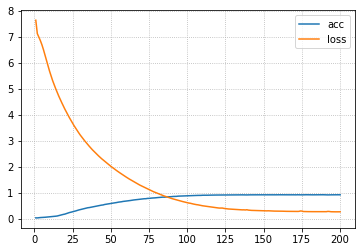

In [ ]:
import matplotlib.pyplot as plt

y_acc = hist.history['accuracy']
y_loss = hist.history['loss']
xs = np.arange(1, len(y_acc)+1)

plt.plot(xs, y_acc, label = 'acc')
plt.plot(xs, y_loss, label = 'loss')
plt.legend(), plt.grid(linestyle = ':')
plt.show()